In [ ]:
import numpy as np
import random as rn
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import combinations
from sklearn.decomposition import PCA

In [ ]:
#sign function (activation)
def sgn(x):
  return np.where(x >= 0, 1, -1)

In [ ]:
#add noise to pattern vecs
def add_noise(pattern, p=0.05):
    flip_mask = np.random.choice([1, -1], size=len(pattern), p=[1-p, p])
    return pattern * flip_mask

In [ ]:
def hebbianWeight(y):
  n = np.size(y)
  W = np.outer(y,y) - np.eye(n)
  return W

In [ ]:
def DHN(input, memory, W, n, maxit = 750):
  x = input.copy()
  success = False
  for i in range(0, maxit):
    unit = rn.randint(0, n - 1)
    x[unit] = sgn((W[unit, :] @ x))
    if np.array_equal(x, memory):
      success = True
      break
  return x, success

In [ ]:
#generate patterns with appropriate hamming dist
def makePatterns(n, N, min_dist=0.3, max_tries=1000):
    patterns = []

    while len(patterns) < N:
        candidate = np.random.choice([-1, 1], size=n)
        if not patterns:
            patterns.append(candidate)
            continue

        # Compute normalized Hamming distances to existing patterns
        dists = [np.mean(candidate != p) for p in patterns]
        if all(d > min_dist for d in dists):
            patterns.append(candidate)
        else:
            max_tries -= 1
            if max_tries <= 0:
                print("Warning: max_tries reached; relaxing distance constraint.")
                break

    return np.array(patterns).T  # shape (n, N)

In [ ]:
#test accuarcy of DHN and return percentage
def testAcc(patterns, W, p=0.05, trials=30):
  n = len(patterns[:,0])
  N = len(patterns[0,:])
  acc = 0
  total = N * trials
  for i in range(0, N):
    for j in range(0, trials):
      y = patterns[:,i].copy()
      x = add_noise(y, p)
      test, result = DHN(x, y, W, n)
      if result == True:
        acc += (100 / total)
  return acc


In [ ]:
def hamming_distance(p, q):
    return np.sum(p != q)

In [ ]:
def energy(x, W):
    return -0.5 * x @ (W @ x)

In [ ]:
def overlap(x, p):
    return (x @ p) / x.size

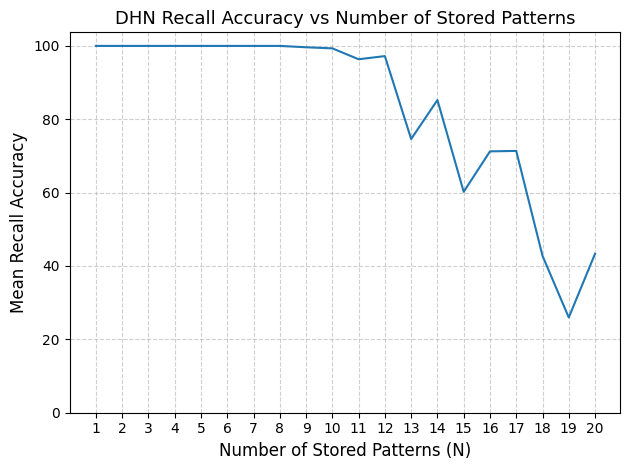

In [ ]:
N = 20
n = 100
accuracy = np.zeros(N)

for k in range(1, N+1):
  patterns = makePatterns(n, k)
  W = np.zeros((n,n))
  W = sum(np.outer(patterns[:, i], patterns[:, i]) for i in range(k)) / k
  np.fill_diagonal(W, 0)
  accuracy[k-1] = testAcc(patterns, W)



plt.plot(np.linspace(1, 20, 20), accuracy)

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xticks(range(1, N+1))
plt.title("DHN Recall Accuracy vs Number of Stored Patterns", fontsize=13)
plt.xlabel("Number of Stored Patterns (N)", fontsize=12)
plt.ylabel("Mean Recall Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

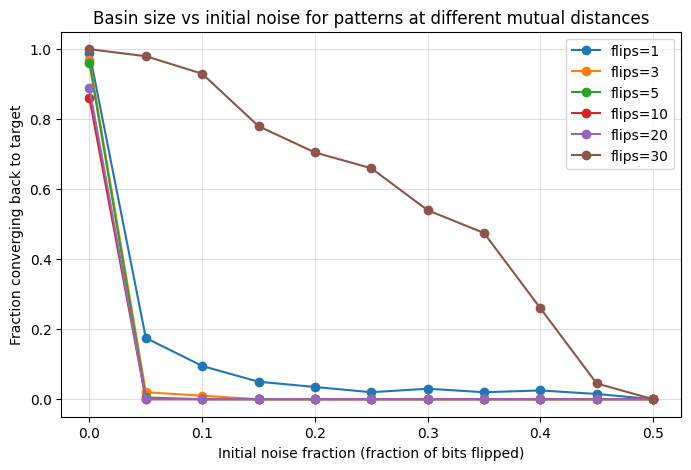

In [ ]:
def make_close_patterns(n, k, flips):
    base = np.where(np.random.rand(n) < 0.5, 1, -1)
    patterns = np.zeros((n, k), dtype=int)
    for i in range(k):
        p = base.copy()
        idx = np.random.choice(n, size=flips, replace=False)
        p[idx] = -p[idx]
        patterns[:, i] = p
    return patterns

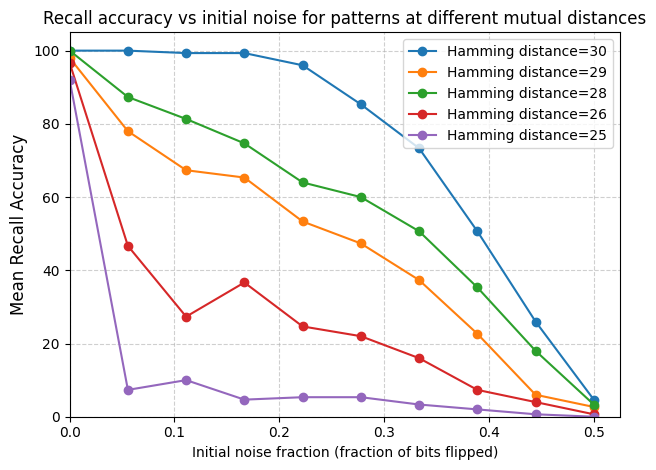

In [ ]:
n = 100
N = 5
p_vals = np.linspace(0, 0.5, 10)
dist_vals = [30, 29, 28, 26, 25]

for j in range(0, 5):
  patterns = make_close_patterns(n, N, dist_vals[j])
  W = np.zeros((n,n))
  W = sum(np.outer(patterns[:, i], patterns[:, i]) for i in range(N)) / N
  np.fill_diagonal(W, 0)

  accuracy = np.zeros(len(p_vals))
  for i in range (0, 10):
    accuracy[i] = testAcc(patterns, W, p_vals[i])

  plt.plot(p_vals, accuracy, marker='o', label=f'Hamming distance={dist_vals[j]}')

plt.xlim(left=0)
plt.ylim(bottom=0)
#plt.xticks(range(1, N+1))
plt.xlabel("Initial noise fraction (fraction of bits flipped)")
plt.ylabel("Mean Recall Accuracy", fontsize=12)
plt.title("Recall accuracy vs initial noise for patterns at different mutual distances")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

